v6-1c

CIFAR10 32x32

Unet(input_blocks)

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
import random

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [4]:
version = "v7-5(i)c"

OUTPUT_DIR = '/root/' + version + '/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [5]:
def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

In [6]:
class CFG:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_classes = 10
    batch_size = 256

In [7]:
transform_train = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((64,64)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='/root/', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
validation_dataset = datasets.CIFAR10(root='/root/', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=CFG.batch_size, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = CFG.batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [9]:
# Different classes in CIPHAR 10 dataset. 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

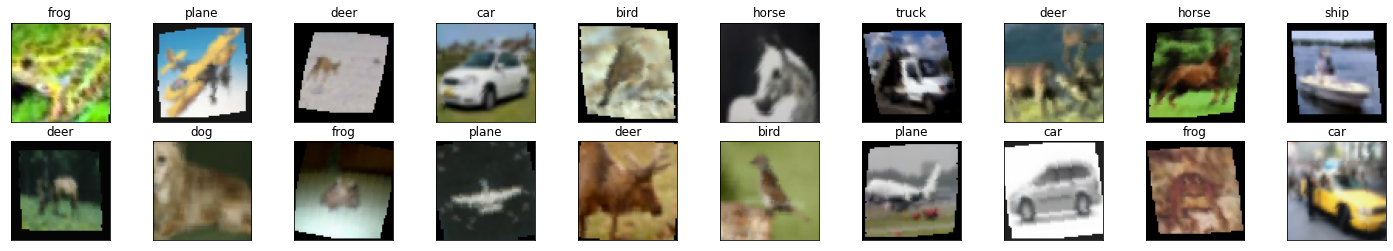

In [10]:
# We iter the batch of images to display
dataiter = iter(training_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = dataiter.next() #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [11]:
from improved_diffusion import dist_util
from improved_diffusion.unet import *

class UNetModel_N(nn.Module):
    """
    The full UNet model with attention and timestep embedding.
    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    """

    def __init__(
        self,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        num_heads=1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.num_heads = num_heads
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        self.input_blocks = nn.ModuleList(
            [
                TimestepEmbedSequential(
                    conv_nd(dims, in_channels, model_channels, 3, padding=1)
                )
            ]
        )
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=mult * model_channels,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch, use_checkpoint=use_checkpoint, num_heads=num_heads
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(
                    TimestepEmbedSequential(Downsample(ch, conv_resample, dims=dims))
                )
                input_block_chans.append(ch)
                ds *= 2
        
        self.fc1 = nn.Linear(2048, 10)
        

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    @property
    def inner_dtype(self):
        """
        Get the dtype used by the torso of the model.
        """
        return next(self.input_blocks.parameters()).dtype

    def forward(self, x, timesteps, y=None):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)
        h = x.type(self.inner_dtype)
        
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        x = F.avg_pool2d(h, 4, 4).view(x.size(0), 2048)
        x = self.fc1(x)
        return x

image_size = 64
channel_mult = (1, 2, 3, 4)
num_channels=128
num_res_blocks=3
num_heads=4
num_heads_upsample=-1
attention_resolutions="16,8"
dropout=0.0
learn_sigma=True
sigma_small=False
class_cond=False
noise_schedule="cosine"
timestep_respacing=""
use_kl=False
predict_xstart=False
rescale_timesteps=True
rescale_learned_sigmas=True
use_checkpoint=False
use_scale_shift_norm=True


def create_model(
    image_size,
    num_channels,
    num_res_blocks,
    learn_sigma,
    class_cond,
    use_checkpoint,
    attention_resolutions,
    num_heads,
    num_heads_upsample,
    use_scale_shift_norm,
    dropout,
):
    if image_size == 256:
        channel_mult = (1, 1, 2, 2, 4, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    elif image_size == 32:
        channel_mult = (1, 2, 2, 2)
    else:
        raise ValueError(f"unsupported image size: {image_size}")

    attention_ds = []
    for res in attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))

    return UNetModel_N(
        in_channels=3,
        model_channels=num_channels,
        out_channels=(3 if not learn_sigma else 6),
        num_res_blocks=num_res_blocks,
        attention_resolutions=tuple(attention_ds),
        dropout=dropout,
        channel_mult=channel_mult,
        num_classes=(NUM_CLASSES if class_cond else None),
        use_checkpoint=use_checkpoint,
        num_heads=num_heads,
        num_heads_upsample=num_heads_upsample,
        use_scale_shift_norm=use_scale_shift_norm,
    )

model = create_model(
        image_size,
        num_channels,
        num_res_blocks,
        learn_sigma=learn_sigma,
        class_cond=class_cond,
        use_checkpoint=use_checkpoint,
        attention_resolutions=attention_resolutions,
        num_heads=num_heads,
        num_heads_upsample=num_heads_upsample,
        use_scale_shift_norm=use_scale_shift_norm,
        dropout=dropout,
    )


In [12]:
model.load_state_dict(
        dist_util.load_state_dict("v7-5(i)/model010000.pt", map_location="cpu"), strict = False
    )
model.to(CFG.device) # run our model on cuda GPU for faster results
print("")

In [13]:
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # fine tuned the lr

In [14]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
LOGGER.info('Step,Train Loss,Train Auc,Valid Loss,Valid Auc')
for e in range(epochs): # training our model, put input according to every batch.
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    train_num = 0
    val_num = 0

    tqdm_bar = tqdm(training_loader, desc=f'Training Epoch {e} ', total=int(len(training_loader)))
    for i, (inputs, labels) in enumerate(tqdm_bar):
        inputs = inputs.to(CFG.device) # input to device as our model is running in mentioned device.
        labels = labels.to(CFG.device)
        
        #t = torch.randint(0, 4000, (len(labels),), device=dist_util.dev()).long()
        t = torch.Tensor([0] * len(labels)).long()
        t = t.to(CFG.device)
        model.train()
        outputs = model(inputs,t) # every batch of 100 images are put as an input.
        loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 

        optimizer.zero_grad() #setting the initial gradient to 0
        loss.backward() # backpropagating the loss
        optimizer.step() # updating the weights and bias values for every single step.

        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.
        
        train_num += len(preds)
        
        tqdm_bar.set_postfix(train_loss=running_loss/(i+1), train_accuracy=running_corrects.item()/(train_num))
    else:
        with torch.no_grad(): # we do not need gradient for validation.
            tqdm_bar = tqdm(validation_loader, desc=f'Validation Epoch {e} ', total=int(len(validation_loader)))
            for i, (val_inputs, val_labels) in enumerate(tqdm_bar):
                val_inputs = val_inputs.to(CFG.device)
                val_labels = val_labels.to(CFG.device)
                
                t = torch.Tensor([0] * len(val_labels)).long()
                t = t.to(CFG.device)
                #t = torch.randint(0, 4000, (len(val_labels),), device=dist_util.dev()).long()
                model.eval()
                val_outputs = model(val_inputs, t)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
                val_num += len(val_preds)
                
                tqdm_bar.set_postfix(val_loss=val_running_loss/(i+1), val_accuracy=val_running_corrects.item()/(val_num))
      
        epoch_loss = running_loss/len(training_loader) # loss per epoch
        epoch_acc = running_corrects.float()/ train_num # accuracy per epoch
        running_loss_history.append(epoch_loss) # appending for displaying 
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ val_num
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        # LOGGER.info('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        # LOGGER.info('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        LOGGER.info('{:d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format((e+1) * len(training_loader), epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))

Step,Train Loss,Train Auc,Valid Loss,Valid Auc
/tmp/ipykernel_476/400436909.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_bar = tqdm(training_loader, desc=f'Training Epoch {e} ', total=int(len(training_loader)))


Training Epoch 0 :   0%|          | 0/196 [00:00<?, ?it/s]

/tmp/ipykernel_476/400436909.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_bar = tqdm(validation_loader, desc=f'Validation Epoch {e} ', total=int(len(validation_loader)))


Validation Epoch 0 :   0%|          | 0/40 [00:00<?, ?it/s]

196, 0.9840, 0.6514, 0.6211, 0.7834


epoch : 1
training loss: 0.9840, acc 0.6514 
validation loss: 0.6211, validation acc 0.7834 


Training Epoch 1 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 1 :   0%|          | 0/40 [00:00<?, ?it/s]

392, 0.5777, 0.7996, 0.5557, 0.8126


epoch : 2
training loss: 0.5777, acc 0.7996 
validation loss: 0.5557, validation acc 0.8126 


Training Epoch 2 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 2 :   0%|          | 0/40 [00:00<?, ?it/s]

588, 0.4691, 0.8372, 0.3939, 0.8648


epoch : 3
training loss: 0.4691, acc 0.8372 
validation loss: 0.3939, validation acc 0.8648 


Training Epoch 3 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 3 :   0%|          | 0/40 [00:00<?, ?it/s]

784, 0.4005, 0.8607, 0.3976, 0.8610


epoch : 4
training loss: 0.4005, acc 0.8607 
validation loss: 0.3976, validation acc 0.8610 


Training Epoch 4 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 4 :   0%|          | 0/40 [00:00<?, ?it/s]

980, 0.3483, 0.8803, 0.3420, 0.8865


epoch : 5
training loss: 0.3483, acc 0.8803 
validation loss: 0.3420, validation acc 0.8865 


Training Epoch 5 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 5 :   0%|          | 0/40 [00:00<?, ?it/s]

1176, 0.3061, 0.8936, 0.3028, 0.8952


epoch : 6
training loss: 0.3061, acc 0.8936 
validation loss: 0.3028, validation acc 0.8952 


Training Epoch 6 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 6 :   0%|          | 0/40 [00:00<?, ?it/s]

1372, 0.2784, 0.9035, 0.3054, 0.8973


epoch : 7
training loss: 0.2784, acc 0.9035 
validation loss: 0.3054, validation acc 0.8973 


Training Epoch 7 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 7 :   0%|          | 0/40 [00:00<?, ?it/s]

1568, 0.2555, 0.9108, 0.2694, 0.9105


epoch : 8
training loss: 0.2555, acc 0.9108 
validation loss: 0.2694, validation acc 0.9105 


Training Epoch 8 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 8 :   0%|          | 0/40 [00:00<?, ?it/s]

1764, 0.2324, 0.9189, 0.2602, 0.9127


epoch : 9
training loss: 0.2324, acc 0.9189 
validation loss: 0.2602, validation acc 0.9127 


Training Epoch 9 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 9 :   0%|          | 0/40 [00:00<?, ?it/s]

1960, 0.2074, 0.9274, 0.2647, 0.9144


epoch : 10
training loss: 0.2074, acc 0.9274 
validation loss: 0.2647, validation acc 0.9144 


Training Epoch 10 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 10 :   0%|          | 0/40 [00:00<?, ?it/s]

2156, 0.1977, 0.9314, 0.2835, 0.9098


epoch : 11
training loss: 0.1977, acc 0.9314 
validation loss: 0.2835, validation acc 0.9098 


Training Epoch 11 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 11 :   0%|          | 0/40 [00:00<?, ?it/s]

2352, 0.1792, 0.9386, 0.2237, 0.9244


epoch : 12
training loss: 0.1792, acc 0.9386 
validation loss: 0.2237, validation acc 0.9244 


Training Epoch 12 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 12 :   0%|          | 0/40 [00:00<?, ?it/s]

2548, 0.1682, 0.9421, 0.2935, 0.9091


epoch : 13
training loss: 0.1682, acc 0.9421 
validation loss: 0.2935, validation acc 0.9091 


Training Epoch 13 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 13 :   0%|          | 0/40 [00:00<?, ?it/s]

2744, 0.1522, 0.9462, 0.2466, 0.9182


epoch : 14
training loss: 0.1522, acc 0.9462 
validation loss: 0.2466, validation acc 0.9182 


Training Epoch 14 :   0%|          | 0/196 [00:00<?, ?it/s]

Validation Epoch 14 :   0%|          | 0/40 [00:00<?, ?it/s]

2940, 0.1408, 0.9496, 0.2587, 0.9215


epoch : 15
training loss: 0.1408, acc 0.9496 
validation loss: 0.2587, validation acc 0.9215 
